In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import skimage.io as io
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img
import tensorflow.keras.backend as k
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tensorflow.python.keras.optimizers import TFOptimizer
from tensorflow.keras import backend as K
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math
import matplotlib.pyplot as plt
import random

data_dir = 'dataset/'
data_mode = ['train/', 'validation/', 'test/']
image_size = 256
batch_size = 8
image_path_train = data_dir + data_mode[0] + 'data/'
label_path_train = data_dir + data_mode[0] + 'label/'
image_path_val = data_dir + data_mode[1] + 'data/'
label_path_val = data_dir + data_mode[1] + 'label/'
image_path_test = data_dir + data_mode[2] + 'data/'
image_path_result = data_dir + data_mode[2] + 'result/'
num_class = 5
Unlabelled = [0, 0, 0]
car = [255, 0, 0]
wheel = [120, 120, 120]
lights = [160, 160, 160]
window = [200, 200, 200]
COLOR_DICT = [Unlabelled, car, wheel, lights, window]
class_name = ["none", "car", "wheel", "lights", "window"]
flag_multi_class = True
epochs = 1
moniter = 'loss'
log_dir = 'log/'
update_freq = 1
histogram_freq = 1

In [2]:
#change current directory up to parent, only run 1 time!
os.chdir("..")

In [3]:
def load_data(test=False,Print=False,path=f'{os.path.abspath(os.curdir)}/data/carseg_data/clean_data',nr_img=1498):
    train_data_input=[]
    train_data_target=[]
    
    for n in range(nr_img):
        n1=n
        if test:
            n1=f'{n}_a'
        try:
            test1=np.load(f'{path}/{n1}.npy')
            inputs=test1[:3].transpose()/255
            inputs=tf.convert_to_tensor(inputs)
            inputs=inputs[tf.newaxis,...]
            target=test1[3].transpose()
            target=tf.convert_to_tensor(target)
            target=target[...,tf.newaxis]
            target=target[tf.newaxis,...]

            
            train_data_input.append(inputs)
            train_data_target.append(target)
        except:
            if Print:
                print(f'fil nr {n} mangeler')
    return [train_data_input,train_data_target]

In [4]:
test_data=load_data(test=True)
train_data=load_data()

In [5]:
def Get_stats(data):
    print(f'Number of training img {len(data[0])}')
    print(f'target sahpe {data[1][0].shape}')
    print(f'input shape {data[0][0].shape}')

print('test_data:')
Get_stats(test_data)
print('train_data:')
Get_stats(train_data)

test_data:
Number of training img 99
target sahpe (1, 256, 256, 1)
input shape (1, 256, 256, 3)
train_data:
Number of training img 1128
target sahpe (1, 256, 256, 1)
input shape (1, 256, 256, 3)


In [6]:
depth = 8
test_data2=tf.one_hot(test_data[1], depth)[:,:,:,:,0,:]
train_data2=tf.one_hot(train_data[1], depth)[:,:,:,:,0,:]

In [7]:
test_data[1]=test_data2
train_data[1]=train_data2

In [8]:
print('test_data:')
Get_stats(test_data)
print('train_data:')
Get_stats(train_data)

test_data:
Number of training img 99
target sahpe (1, 256, 256, 8)
input shape (1, 256, 256, 3)
train_data:
Number of training img 1128
target sahpe (1, 256, 256, 8)
input shape (1, 256, 256, 3)


In [9]:
leakyrelu_alpha = 0.3
dr_rate = 0.6
def unet(pretrained_weights=None, input_size=(256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=leakyrelu_alpha)(conv1)
    #conv1 = Dropout(dr_rate)(conv1) ###
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)    
    conv1 = LeakyReLU(alpha=leakyrelu_alpha)(conv1)
    #conv1 = Dropout(dr_rate)(conv1) ###
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(dr_rate)(pool1) ### 
    
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=leakyrelu_alpha)(conv2)
    #conv2 = Dropout(dr_rate)(conv2)###
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=leakyrelu_alpha)(conv2)    
    #conv2 = Dropout(dr_rate)(conv2)###    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=leakyrelu_alpha)(conv3)
    #conv3 = Dropout(dr_rate)(conv3) ###
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=leakyrelu_alpha)(conv3)
    #conv3 = Dropout(dr_rate)(conv3) ###
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=leakyrelu_alpha)(conv4)    
    #conv4 = Dropout(dr_rate)(conv4) ###
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=leakyrelu_alpha)(conv4)
    drop4 = Dropout(dr_rate)(conv4) ###
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)    

    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)    
    conv5 = LeakyReLU(alpha=leakyrelu_alpha)(conv5)
    #conv5 = Dropout(dr_rate)(conv5) ###
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = LeakyReLU(alpha=leakyrelu_alpha)(conv5)
    #drop5 = Dropout(dr_rate)(conv5) ###

    up6 = Conv2D(512, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU(alpha=leakyrelu_alpha)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=leakyrelu_alpha)(conv6)
    #conv6 = Dropout(dr_rate)(conv6) ###
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=leakyrelu_alpha)(conv6)    
    #conv6 = Dropout(dr_rate)(conv6) ###   

    up7 = Conv2D(256, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7 = BatchNormalization()(up7)    
    up7 = LeakyReLU(alpha=leakyrelu_alpha)(up7)
    up7 = Dropout(dr_rate)(up7) ###
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)    
    conv7 = LeakyReLU(alpha=leakyrelu_alpha)(conv7)    
    #conv7 = Dropout(dr_rate)(conv7) ###
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = LeakyReLU(alpha=leakyrelu_alpha)(conv7)
    #conv7 = Dropout(dr_rate)(conv7) ###   

    up8 = Conv2D(128, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8 = BatchNormalization()(up8)
    up8 = LeakyReLU(alpha=0.3)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = LeakyReLU(alpha=0.3)(conv8)
    #conv8 = Dropout(dr_rate)(conv8) ###
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)    
    conv8 = LeakyReLU(alpha=0.3)(conv8)    
    #conv8 = Dropout(dr_rate)(conv8) ###    

    up9 = Conv2D(64, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9 = BatchNormalization()(up9)
    up9 = LeakyReLU(alpha=leakyrelu_alpha)(up9)
    up9 = Dropout(dr_rate)(up9) ###
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv9 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)    
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv10 = Conv2D(8, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    def compute_loss(y, y_pred):
        y_true_f = K.flatten(y)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f))
        return -dice

    model.compile(optimizer=Adam(lr=1e-4), loss=compute_loss, metrics=['accuracy'])

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

 rmalization)                   )                                                                 
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 16, 16, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 1024  9438208     ['leaky_re_lu_8[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 1024  4096       ['conv2d_9[0][0]']               
 rmalization)                   )                                                                 
          

C:\Users\mikke\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 conv2d_17 (Conv2D)             (None, 128, 128, 12  295040      ['concatenate_2[0][0]']          
                                8)                                                                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 128, 128, 12  512        ['conv2d_17[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)     (None, 128, 128, 12  0           ['batch_normalization_16[0][0]'] 
                                8)                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 128, 128, 12  147584      ['leaky_re_lu_17[0][0]']         
          

In [16]:
class testgenerator(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        #idx=random.randint(0,len(self.x)-1-batch_size)
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array(batch_x),np.array(batch_y)

In [17]:
batch_size=15
train_data_gen = testgenerator(train_data[0][0],train_data[1][0],batch_size)

val_data_gen = testgenerator(test_data[0][0],test_data[1][0],1)

In [18]:
history = model.fit_generator(train_data_gen, epochs=100, steps_per_epoch=5)

C:\Users\mikke\AppData\Local\Temp/ipykernel_32468/3670043425.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen, epochs=100, steps_per_epoch=5)


Epoch 1/100
5/5 [==============================] - 8s 17ms/step - loss: -0.1091 - accuracy: 0.2534


In [19]:
result = model.predict(test_data[0][1])

In [20]:
print(result.shape)

(1, 256, 256, 8)


In [21]:
print(result)

[[[[0.12503956 0.12490135 0.12482596 ... 0.12476344 0.12509319
    0.12511581]
   [0.12513106 0.12498906 0.12485426 ... 0.12484552 0.12506048
    0.12508465]
   [0.12516594 0.12499896 0.12482816 ... 0.12482468 0.12506944
    0.12509888]
   ...
   [0.12512109 0.12498973 0.1248672  ... 0.12485924 0.12505469
    0.12507668]
   [0.12517779 0.12497541 0.12477713 ... 0.12475801 0.12509702
    0.1251336 ]
   [0.12514006 0.12492673 0.12474587 ... 0.12469648 0.12512197
    0.12516038]]

  [[0.12495518 0.12490994 0.12494025 ... 0.12488607 0.12504171
    0.1250451 ]
   [0.12495756 0.12494498 0.12499236 ... 0.12496083 0.12501094
    0.12500788]
   [0.12497845 0.12496568 0.12499989 ... 0.12498108 0.12500288
    0.12500004]
   ...
   [0.12474252 0.12489459 0.12517071 ... 0.12511371 0.12494536
    0.12490769]
   [0.12493349 0.12489044 0.12493557 ... 0.12486948 0.12504826
    0.12505104]
   [0.12494358 0.12486966 0.1248909  ... 0.12481102 0.12507245
    0.12508143]]

  [[0.12476969 0.12485825 0.125081

<function matplotlib.pyplot.show(close=None, block=None)>

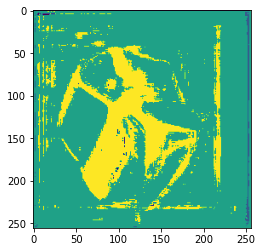

In [23]:
plt.imshow(tf.argmax(result[0],axis=-1))
plt.show